# Predicting Stock Prices with Linear Regression

To answer the question if we can accurately predict stock prices over time, I'm going to use Stock Price history data from the Quadl API and apply a regression analysis method.

## Check out the Data

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import quandl
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

### Configure Quandl

In [2]:
#https://medium.com/@randerson112358/predict-stock-prices-using-python-machine-learning-53aa024da20a
# Get the stock data

quandl.ApiConfig.api_key = 'qKYyca8_q3vn5ws7FpwZ'


# Set start and end date for stock prices
start_date = datetime.date(2009, 1,31)
end_date = datetime.date.today()

df = quandl.get('WIKI/AAPL', start_date=start_date, end_date=end_date)
# Take a look at the data
#df.head()

#df = quandl.get_table('WIKI/PRICES', ticker = ['AAPL'], 
#                        qopts = { 'columns': ['date', 'adj_close'] }, 
#                       date = { 'gte': '2012-03-15', 'lte': '2018-03-15' }, 
#                        paginate=True)
df.to_csv('salesforce_stock.csv')

### Get the Data

In [3]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2009-02-02,89.10,92.00,88.90,91.51,19937400.0,0.0,1.0,11.450592,11.823282,11.424889,11.760310,139561800.0
2009-02-03,91.92,93.38,90.28,92.98,21403900.0,0.0,1.0,11.813001,12.000631,11.602238,11.949226,149827300.0
2009-02-04,93.24,96.25,93.10,93.55,28872200.0,0.0,1.0,11.982640,12.369466,11.964648,12.022479,202105400.0
2009-02-05,92.77,97.25,92.62,96.46,26758800.0,0.0,1.0,11.922238,12.497980,11.902961,12.396454,187311600.0
2009-02-06,97.00,100.00,97.00,99.72,24543200.0,0.0,1.0,12.465852,12.851394,12.465852,12.815410,171802400.0


In [4]:
# Check data types in columns
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2302 entries, 2009-02-02 to 2018-03-27
Data columns (total 12 columns):
Open           2302 non-null float64
High           2302 non-null float64
Low            2302 non-null float64
Close          2302 non-null float64
Volume         2302 non-null float64
Ex-Dividend    2302 non-null float64
Split Ratio    2302 non-null float64
Adj. Open      2302 non-null float64
Adj. High      2302 non-null float64
Adj. Low       2302 non-null float64
Adj. Close     2302 non-null float64
Adj. Volume    2302 non-null float64
dtypes: float64(12)
memory usage: 233.8 KB


In [5]:
# Get descriptive statistics summary of data set 
df.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,2302.000000,2302.000000,2302.000000,2302.000000,2.302000e+03,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2.302000e+03
mean,275.594724,278.102318,272.790286,275.509234,2.734093e+07,0.013236,1.002606,79.540479,80.223821,78.810157,79.534439,8.953108e+07
std,176.187835,177.699997,174.318586,176.012673,1.841446e+07,0.177549,0.125054,42.206632,42.496327,41.913212,42.209329,6.086191e+07
min,84.120000,87.600000,82.330000,83.110000,5.624800e+06,0.000000,1.000000,10.810592,11.257821,10.580552,10.680793,1.147592e+07
25%,119.202500,120.117500,118.435000,119.562500,1.476375e+07,0.000000,1.000000,44.724135,44.979878,44.407349,44.744698,4.078568e+07
50%,195.050000,196.700000,191.695000,194.255000,2.190160e+07,0.000000,1.000000,73.774172,74.184030,73.088511,73.537603,7.670496e+07
75%,423.167500,426.895000,419.647500,422.512500,3.403747e+07,0.000000,1.000000,108.505538,109.864139,107.593791,108.873706,1.201751e+08
max,702.410000,705.070000,699.570000,702.100000,1.895606e+08,3.290000,7.000000,182.590000,183.500000,180.210000,181.720000,4.702495e+08


In [6]:
# Display features in data set
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'],
      dtype='object')

### Select Subset with relevant features

We use the daily closing price **Close** as the value to predict, so we can discard the other features.  

* 'Close' column has numerical data type
* The 'Date' is the index column and contains datetime values

In [9]:
# Create a new DataFrame with only closing price and date
lr_prediction_list = []
stock_close_df = []

df1 = pd.DataFrame(df, columns=['Adj. Close'])
forecast_out = 2
df1['Prediction'] = df1[['Adj. Close']].shift(-forecast_out)
df['Prediction'] = df[['Adj. Close']].shift(-forecast_out)
        
# Define X data set
X = np.array(df.drop(['Prediction'],1))
X = X[:-forecast_out]
        
# Define Y data set
y = np.array(df['Prediction'])
y = y[:-forecast_out]

# Split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create and train the Linear Regression  Model
lr = LinearRegression()
# Train the model
lr.fit(x_train, y_train)

lr_confidence = lr.score(x_test, y_test)
x_forecast = np.array(df.drop(['Prediction'],1))[-forecast_out:]
        
# Prediction
lr_prediction = lr.predict(x_forecast)

lr_prediction

array([172.31370638, 169.60861276])

In [10]:
value1 = lr_prediction[0]
value2 = lr_prediction[1]

length = len(df1)

df1.at['2018-03-26 00:00:00', 'Prediction'] = value1
df1.at['2018-03-27 00:00:00', 'Prediction'] = value2

In [11]:
df1.tail()

,Adj. Close,Prediction
Date,,
2018-03-21,171.270,164.940000
2018-03-22,168.845,172.770000
2018-03-23,164.940,168.340000
2018-03-26,172.770,172.313706
2018-03-27,168.340,169.608613


In [13]:
df1 = df1.reset_index()

In [14]:
df1.tail()

,Date,Adj. Close,Prediction
2297,2018-03-21,171.270,164.940000
2298,2018-03-22,168.845,172.770000
2299,2018-03-23,164.940,168.340000
2300,2018-03-26,172.770,172.313706
2301,2018-03-27,168.340,169.608613


In [15]:
# Check data types in columns
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 3 columns):
Date          2302 non-null datetime64[ns]
Adj. Close    2302 non-null float64
Prediction    2302 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 54.0 KB


In [16]:
# Check for missing values in the columns
df1.isna().values.any()

False


## Explore the Data

When we take a look at the price movement over time by simply plotting the *Closing price* vs *Time*, we can already see, that the price continously increases over time and we can also estimate that trend could be linear.

C:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


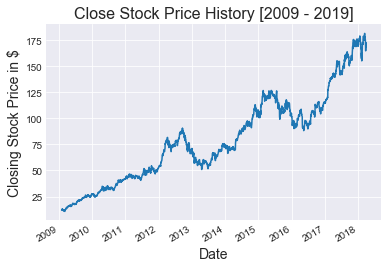

In [17]:
# Import matplotlib package for date plots
import matplotlib.dates as mdates

years = mdates.YearLocator() # Get every year
yearsFmt = mdates.DateFormatter('%Y') # Set year format

# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
ax.plot(df1['Date'], df['Adj. Close'])

# Format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

# Set figure title
plt.title('Close Stock Price History [2009 - 2019]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

## Linear Regression
 
Our data contains only one **independent variable ($X$)** which represents the *date* and the **dependent variable ($Y$)** we are trying to predict is the *Stock Price*. To fit a line to the data points, which then represents an estimated relationship between $X$ and $Y$, we can use a **Simple Linear Regression**.

The best fit line can be described with  
$$
Y = \beta_0 + \beta_1 X
$$

where  
* $Y$ is the predicted value of the dependent variable
* $\beta_0$ is the y-intercept
* $\beta_1$ is the slope
* $X$ is the value of the independent variable

The goal is to find such coefficients $\beta_0$ and $\beta_1$ that the **Sum of Squared Errors**, which represents the difference between each point in the dataset with it’s corresponding predicted value outputted by the model, is minimal.

### Training a Linear Regression Model

### Train Test Split

In [18]:
# Import package for splitting data set
from sklearn.model_selection import train_test_split

In [19]:
# Split data into train and test set: 80% / 20%
train, test = train_test_split(df1, test_size=0.20)

### Create and Train the Model

In [20]:
# Import package for linear model
from sklearn.linear_model import LinearRegression

In [21]:
# Reshape index column to 2D array for .fit() method
X_train = np.array(train.index).reshape(-1, 1)
y_train = train['Adj. Close']

In [22]:
# Create LinearRegression Object
model = LinearRegression()
# Fit linear model using the train data set
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Model Evaluation

In [23]:
# The coefficient
print('Slope: ', np.asscalar(np.squeeze(model.coef_)))
# The Intercept
print('Intercept: ', model.intercept_)

Slope:  0.06021460627053846
Intercept:  10.233741048211755



Interpreting the coefficients:

* The **slope** coefficient tells us that with a 1 unit increase in **date** the **closing price** increases by 0.0276 $
* The **intercept** coefficient is the price at wich the **closing price** measurement started, the stock price value at date zero

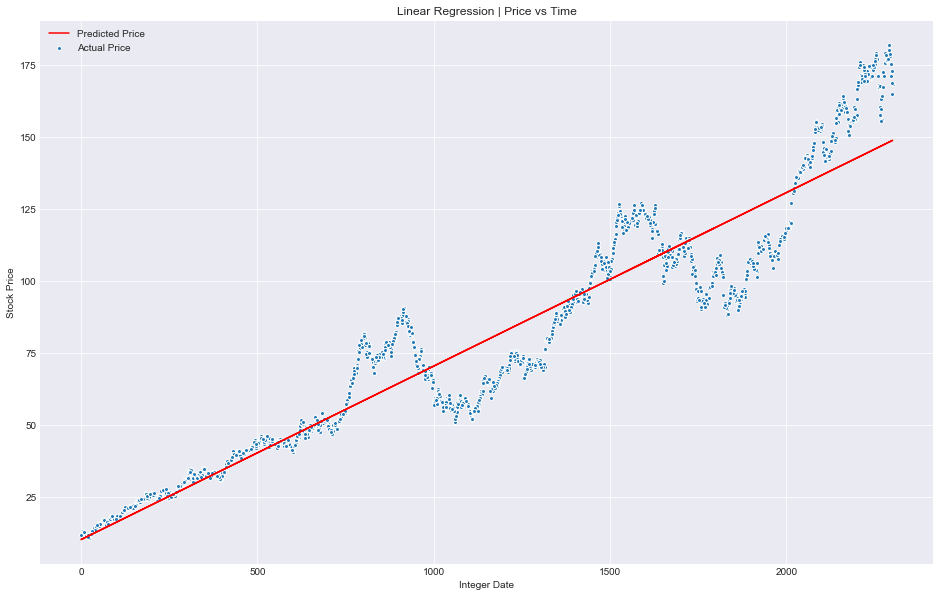

In [24]:
# Train set graph
plt.figure(1, figsize=(16,10))
plt.title('Linear Regression | Price vs Time')
plt.scatter(X_train, y_train, edgecolor='w', label='Actual Price')
plt.plot(X_train, model.predict(X_train), color='r', label='Predicted Price')
plt.xlabel('Integer Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Prediction from our Model

In [25]:
# Create test arrays
X_test = np.array(test.index).reshape(-1, 1)
y_test = test['Adj. Close']

In [26]:
# Generate array with predicted values
y_pred = model.predict(X_test)

## Regression Evaluation

Let's have a look at how the predicted values compare with the actual value on random sample from our data set.

In [27]:
# Get number of rows in data set for random sample
df1.shape

(2302, 3)

In [28]:
# Generate 25 random numbers
randints = np.random.randint(len(df1), size=25)

# Select row numbers == random numbers
df1_sample = df1[df1.index.isin(randints)]

In [29]:
df1_sample.head()

,Date,Adj. Close,Prediction
82,2009-06-01,17.908417,18.114040
226,2009-12-23,25.972667,27.194834
242,2010-01-19,27.635637,26.740152
251,2010-02-01,25.025519,25.603832
522,2011-02-28,45.392408,45.252328


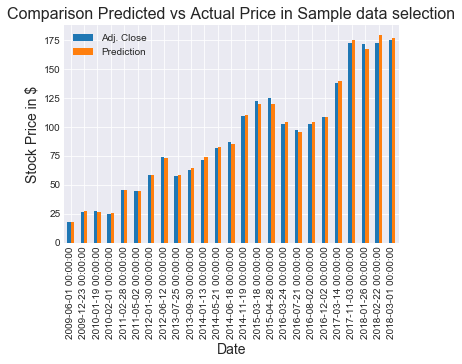

In [30]:
# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
df1_sample.plot(x='Date', y=['Adj. Close', 'Prediction'], kind='bar', ax=ax)

# Set figure title
plt.title('Comparison Predicted vs Actual Price in Sample data selection', fontsize=16)

# 

# Set x label
plt.xlabel('Date', fontsize=14)

# Set y label
plt.ylabel('Stock Price in $', fontsize=14)

# Show plot
plt.show()

We can see some larger variations between predicted and actual values in the random sample.  
Let's see how the model performed over the whole test data set. 

TypeError: __init__() got an unexpected keyword argument 'label'

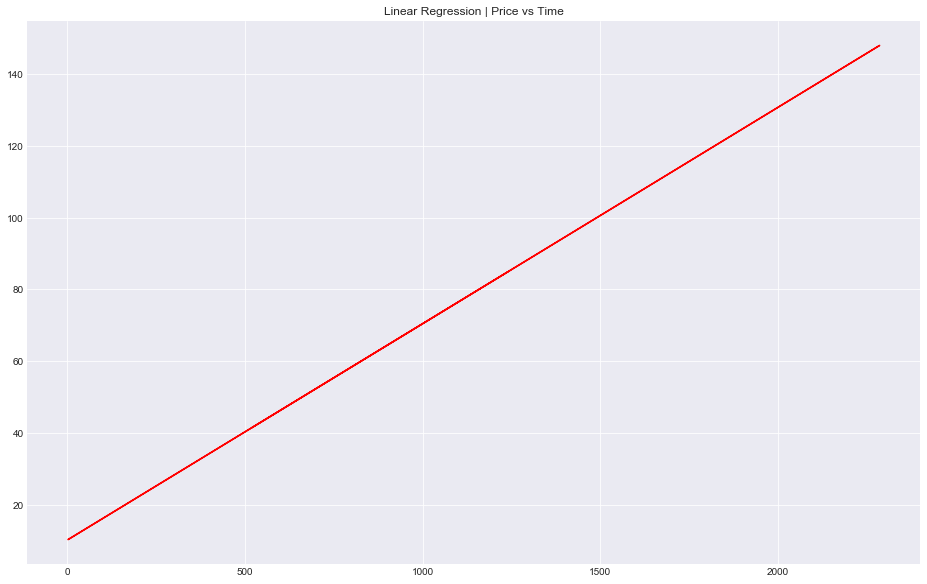

In [31]:
# Plot fitted line, y test
plt.figure(1, figsize=(16,10))
plt.title('Linear Regression | Price vs Time')
plt.plot(X_test, model.predict(X_test), color='r', label='Predicted Price')
plt.subplots(X_test, y_test, edgecolor='w', label='Actual Price')

plt.xlabel('Integer Date')
plt.ylabel('Stock Price in $')

plt.show()

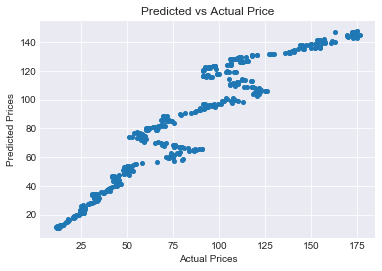

In [32]:
# Plot predicted vs actual prices
plt.scatter(y_test, y_pred)

plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

plt.title('Predicted vs Actual Price')

plt.show()

The data points are mostly close to a diagonal, which indicates, that the predicted values are close to the actual value and the model's performance is largerly quite good.  
Yet there are some areas, around 55 to 65, the model seems to be quite random and shows no relationship between the predicted and actual value.  
Also in the area around 85 - 110 the data point are spread out quite heavily and the predictions don't cover the values above 100.

#### Residual Histogram

The residuals are nearly normally distributed around zero, with a slight skewedness to the right. 

In [ ]:
# Import norm package to plot normal distribution
from scipy.stats import norm

# Fit a normal distribution to the data:
mu, std = norm.fit(y_test - y_pred)

ax = sns.distplot((y_test - y_pred), label='Residual Histogram & Distribution')

# Calculate the pdf over a range of values         
x = np.linspace(min(y_test - y_pred), max(y_test - y_pred), 100)
p = norm.pdf(x, mu, std)

# And plot on the same axes that seaborn put the histogram
ax.plot(x, p, 'r', lw=2, label='Normal Distribution') 

plt.legend()
plt.show()

In [ ]:
# Add new column for predictions to df
# df1['Prediction'] = model.predict(np.array(df.index).reshape(-1, 1))

In [ ]:
df1.head()

### Error Evaluation Metrics

**Mean Absolute Error (MAE)** is the mean of the absolute value of the errors:
$$
\frac{1}{N} \sum_{i = 1}^{N} |y_i - \hat{y}_i|
$$

**Mean Squared Error (MSE)** is the mean of the squared errors:
$$
\frac{1}{N} \sum_{i = 1}^{N} (y_i - \hat{y}_i)^2
$$

**Root Mean Squared Error (RMSE)** is the square root of the mean of the squared errors:
$$
\sqrt{\frac{1}{N} \sum_{i = 1}^{N} (y_i - \hat{y}_i)^2}
$$

All of these are **cost functions** we want to minimize.

In [ ]:
# Import metrics package from sklearn for statistical analysis
from sklearn import metrics

In [ ]:
# Statistical summary of test data
df['Close'].describe()

In [ ]:
# Calculate and print values of MAE, MSE, RMSE
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

* The MAE is 3% (of minimum) and 6% (of maximum) of the Closing Price.
* The other two errors are larger, because the errors are squared and have therefore a greater influence on the result.

### Accuracy Evaluation Metrics

To see how accurate our model is, we can calculate the **Coefficient of determination**, which describes the ratio between the total error and the error, that is explained by our model. It's value is between 0 and 1, with 1 meaning 100% of the error is acoounted for by the model. 

**Coefficient of determination**
$$
R^2 = 1 - \frac{RSS}{TSS}
$$

with  

**Residual Sum of Squares (RSS)**
$$
RSS = \sum_{i = 1}^{N} \epsilon_i^2 = \sum_{i = 1}^{N} (y_i - \hat{y}_i)^2
$$

**Total Sum of Squares (TSS)**
$$
TSS = \sum_{i = 1}^{N} (y_i - \bar{y}_i)^2
$$


In [ ]:
print('R2: ', metrics.r2_score(y_test, y_pred))

In [ ]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, y_pred)

The value of $R^2$ shows that are model accounts for nearly 94% of the differences between the actual stock prices and the predicted prices. 